In [194]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

from statsmodels.tsa import arima_model

from sklearn import preprocessing, neighbors, grid_search, cross_validation
from sklearn import metrics

%matplotlib inline
plt.style.use('ggplot')

In [195]:
df = pd.read_csv(os.path.join('energy_consumption_final.csv'))


In [196]:
df

,Year,Biomass,Coal,Geothermal,Hydroelectric,Natural Gas (Excluding Supplemental Gaseous Fuels),Nuclear,Petroleum (Excluding Biofuels),Solar,Wind
0,1949,1.549262,11.980905,NaN,1.424722,5.145142,0.000000,11.882722,NaN,NaN
1,1950,1.562307,12.347109,NaN,1.415411,5.968371,0.000000,13.315484,NaN,NaN
2,1951,1.534669,12.552996,NaN,1.423795,7.048518,0.000000,14.428043,NaN,NaN
3,1952,1.474369,11.306479,NaN,1.465812,7.549621,0.000000,14.955682,NaN,NaN
4,1953,1.418601,11.372684,NaN,1.412859,7.906645,0.000000,15.555829,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
62,2011,4.405452,19.657784,0.212311,3.102852,24.954539,8.268698,34.823508,0.105285,1.167636
63,2012,4.369122,17.378234,0.211592,2.628702,26.088582,8.061822,34.015932,0.148110,1.340059
64,2013,4.673160,18.038633,0.214006,2.562382,26.805134,8.244433,34.608605,0.212775,1.601359
65,2014,4.812322,17.997632,0.214490,2.466577,27.382872,8.337559,34.881101,0.321174,1.727542


In [197]:
df.dropna(inplace = True)

df.isnull().sum().sum()

0

After dropping null values, the time series analysis will begin in the year 1984 to the present. Some energy sources did not have historical data before 1984. knn analysis might be conducted to predict what these values might have been if necessary.


In [198]:
df

,Year,Biomass,Coal,Geothermal,Hydroelectric,Natural Gas (Excluding Supplemental Gaseous Fuels),Nuclear,Petroleum (Excluding Biofuels),Solar,Wind
35,1984,2.971120,17.070622,0.080811,3.385811,18.393613,3.552531,31.053237,0.000055,0.000068
36,1985,3.016233,17.478428,0.097421,2.970192,17.703482,4.075563,30.924732,0.000111,0.000060
37,1986,2.932095,17.260405,0.107677,3.071179,16.591364,4.380109,32.198260,0.000147,0.000044
38,1987,2.874884,18.008451,0.112270,2.634508,17.639801,4.753933,32.863733,0.000109,0.000037
39,1988,3.016049,18.846312,0.106338,2.334265,18.448393,5.586968,34.222795,0.000094,0.000009
...,...,...,...,...,...,...,...,...,...,...
62,2011,4.405452,19.657784,0.212311,3.102852,24.954539,8.268698,34.823508,0.105285,1.167636
63,2012,4.369122,17.378234,0.211592,2.628702,26.088582,8.061822,34.015932,0.148110,1.340059
64,2013,4.673160,18.038633,0.214006,2.562382,26.805134,8.244433,34.608605,0.212775,1.601359
65,2014,4.812322,17.997632,0.214490,2.466577,27.382872,8.337559,34.881101,0.321174,1.727542


In [199]:
df['Year'] = pd.to_datetime(df['Year'], format = '%Y')
df.set_index('Year', drop=True, inplace=True)
df.columns = [col.strip() for col in df.columns]
df.head()

,Biomass,Coal,Geothermal,Hydroelectric,Natural Gas (Excluding Supplemental Gaseous Fuels),Nuclear,Petroleum (Excluding Biofuels),Solar,Wind
Year,,,,,,,,,
1984-01-01,2.971120,17.070622,0.080811,3.385811,18.393613,3.552531,31.053237,0.000055,0.000068
1985-01-01,3.016233,17.478428,0.097421,2.970192,17.703482,4.075563,30.924732,0.000111,0.000060
1986-01-01,2.932095,17.260405,0.107677,3.071179,16.591364,4.380109,32.198260,0.000147,0.000044
1987-01-01,2.874884,18.008451,0.112270,2.634508,17.639801,4.753933,32.863733,0.000109,0.000037
1988-01-01,3.016049,18.846312,0.106338,2.334265,18.448393,5.586968,34.222795,0.000094,0.000009


In [200]:
df.corr()

,Biomass,Coal,Geothermal,Hydroelectric,Natural Gas (Excluding Supplemental Gaseous Fuels),Nuclear,Petroleum (Excluding Biofuels),Solar,Wind
Biomass,1.000000,-0.354257,0.652296,-0.331712,0.734186,0.492697,-0.057722,0.766354,0.964255
Coal,-0.354257,1.000000,0.188700,0.048412,0.161410,0.517437,0.839630,-0.354390,-0.392716
Geothermal,0.652296,0.188700,1.000000,-0.316209,0.863164,0.866756,0.409719,0.679094,0.687918
Hydroelectric,-0.331712,0.048412,-0.316209,1.000000,-0.263870,-0.382393,-0.208694,-0.325243,-0.404779
Natural Gas (Excluding Supplemental Gaseous Fuels),0.734186,0.161410,0.863164,-0.263870,1.000000,0.866141,0.459088,0.783692,0.776190
Nuclear,0.492697,0.517437,0.866756,-0.382393,0.866141,1.000000,0.737428,0.502918,0.526632
Petroleum (Excluding Biofuels),-0.057722,0.839630,0.409719,-0.208694,0.459088,0.737428,1.000000,0.068955,-0.022474
Solar,0.766354,-0.354390,0.679094,-0.325243,0.783692,0.502918,0.068955,1.000000,0.858868
Wind,0.964255,-0.392716,0.687918,-0.404779,0.776190,0.526632,-0.022474,0.858868,1.000000


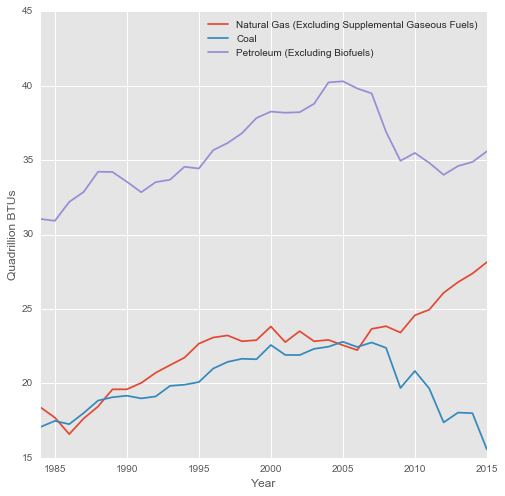

In [201]:
ax = df[['Natural Gas (Excluding Supplemental Gaseous Fuels)', 'Coal', 'Petroleum (Excluding Biofuels)']].plot(label = 'Series', 
                                                                                           figsize = (8,8))
ax.set_ylabel('Quadrillion BTUs')

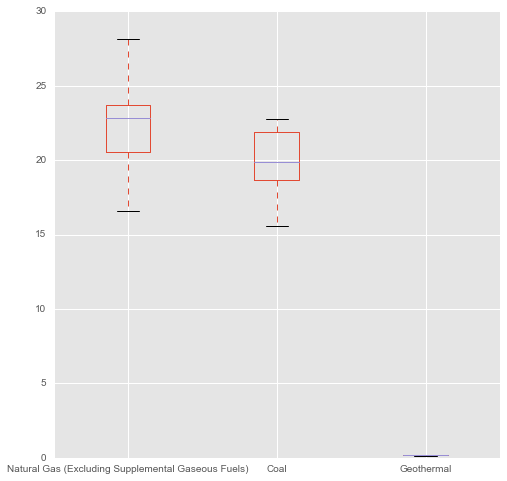

In [202]:
df[['Natural Gas (Excluding Supplemental Gaseous Fuels)', 'Coal', 'Geothermal']].plot(kind='box', figsize = (8,8))

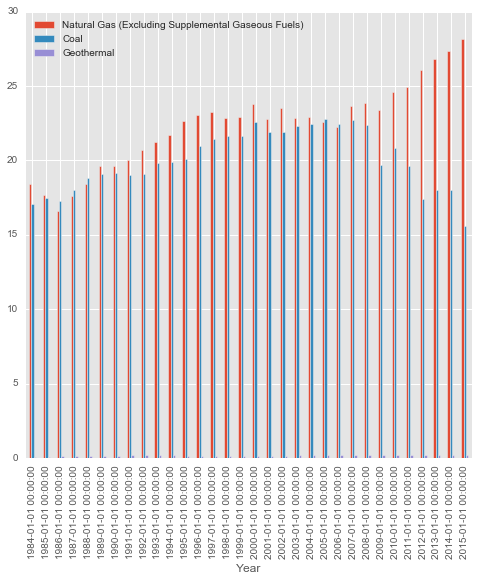

In [203]:
df[['Natural Gas (Excluding Supplemental Gaseous Fuels)', 'Coal', 'Geothermal']].plot(kind='bar', label = 'Series', figsize = (8,8))

In [207]:
n = df.shape[0]
m = int(.75 * n)

train_df = df[: m]
test_df = df[m :]

In [208]:
#arima_model.ARIMA(train_df['global tmp'],order= , exog=train_df.drop['globaltmp'])

In [211]:
model = arima_model.ARIMA(train_df, (1, 0, 0)).fit()



ValueError: could not broadcast input array from shape (9) into shape (1)

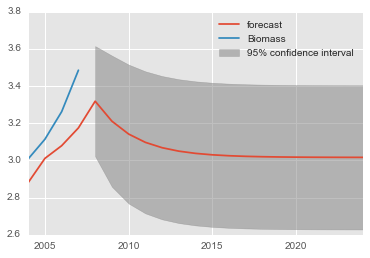

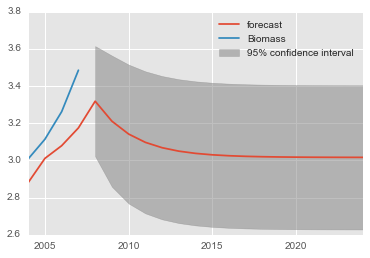

In [210]:
model.plot_predict(20, 40)